# Team 3 Final Project - Modeling

We will be using a variety of Machine Learning Models in an unsupervised manner to produce a Collaborative Filtering based Recommender System.

K Nearest Neigbors will produce the actual recommendations based on cosine similarity between anime titles. Recommendations will be made based on user's last watched anime, this will be the query for KNN. Titles already watched (completed) by the user will be excluded from the dataset for KNN (don't want to recommend already watched titles). The K (default 10) nearest neighbors to the last watched title will be the recommendations.

BERT Model (Bi-Directional Encoder Representations from Transformers) - Default Pre-Trained BERT model will be used on the synopsis table to generate a vector embedding or semantic representation that can be used by KNN to produce more distinct recommendations. **Note: This will significantly increase the complexity of the project and will only be used if there is enough time to implement**

K-Means Clustering - There are currently 36 unique genres that may be too similar and titles can be attached to many genres. We want to simply the genres by generating clusters that will serve to reduce the dimenionality from 36 genres to k - clusters.

In [1]:
!pip install pyathena

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached PyAthena-2.5.1-py3-none-any.whl (40 kB)
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
# This is for MAR@K metrics
#!pip install recmetrics

In [3]:
#!pip install ml_metrics

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from botocore.exceptions import ClientError
import sagemaker
import pyathena as pa
from pyathena.pandas.cursor import PandasCursor
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

In [5]:
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [6]:
# Athena modeling bucket
s3_modeling_dir = 's3://ads508team3/modeling/'
# Athena staging bucket
s3_staging_dir = 's3://ads508team3/athena-staging/'

In [7]:
# Create Connection for pyathena
conn = pa.connect(region_name=region, s3_staging_dir=s3_staging_dir)
cursor = pa.connect(s3_staging_dir=s3_staging_dir, region_name='us-east-1',cursor_class=PandasCursor).cursor()
dbname = 'myanimelist'
table_list = ['animelist', 'anime', 'synopsis', 'ratings', 'watching_status']

## Import training set

In [8]:
# Download Files from S3

s3 = boto3.resource('s3')

try:
    s3.Bucket('ads508team3').download_file('modeling/training.csv', 'Data/training.csv')
    s3.Bucket('ads508team3').download_file('modeling/semantics.csv', 'Data/semantics.csv')
    s3.Bucket('ads508team3').download_file('modeling/anime_subset.csv', 'Data/anime_subset.csv')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [9]:
training = pd.read_csv('Data/training.csv')

In [10]:
training

,user_id,anime_id,user_rating,watching_status,watched_episodes,mal_id,aggregated_score,episodes,rating,ranked,...,Yaoi,Yuri,Movie,Music.2,Music.3,ONA,OVA,Other,Special,TV
0,336145,2251,10,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,228773,2251,9,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,61090,2251,10,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,26848,2251,9,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,195185,2251,8,2,13,2251,8.420000,13.0,5,143.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999991,300428,13503,0,4,0,13503,6.509999,11.0,3,13708.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
999992,30459,34369,0,4,0,34369,6.509999,5.0,3,14403.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,1.0,0.0
999993,275530,7779,0,4,0,7779,6.210000,52.0,2,7295.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
999994,272555,40406,0,4,0,40406,6.509999,16.0,1,15754.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
training.columns

Index(['user_id', 'anime_id', 'user_rating', 'watching_status',
       'watched_episodes', 'mal_id', 'aggregated_score', 'episodes', 'rating',
       'ranked', 'popularity', 'members', 'score_10', 'score_9', 'score_8',
       'score_7', 'score_6', 'score_5', 'score_4', 'score_3', 'score_2',
       'score_1', 'days_since_aired', 'Action', 'Adventure', 'Cars', 'Comedy',
       'Dementia', 'Demons', 'Drama', 'Ecchi', 'Fantasy', 'Game', 'Harem',
       'Hentai', 'Historical', 'Horror', 'Josei', 'Kids', 'Magic',
       'Martial Arts', 'Mecha', 'Military', 'Music', 'Music.1', 'Mystery',
       'Parody', 'Police', 'Psychological', 'Romance', 'Samurai', 'School',
       'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai', 'Shounen', 'Shounen Ai',
       'Slice of Life', 'Space', 'Sports', 'Super Power', 'Supernatural',
       'Thriller', 'Unknown', 'Vampire', 'Yaoi', 'Yuri', 'Movie', 'Music.2',
       'Music.3', 'ONA', 'OVA', 'Other', 'Special', 'TV'],
      dtype='object')

## Import anime subset

Used for KNN of titles

In [12]:
anime_subset = pd.read_csv('Data/anime_subset.csv')

In [13]:
anime_subset

,mal_id,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,...,Yaoi,Yuri,Movie,Music.2,Music.3,ONA,OVA,Other,Special,TV
0,1,8.780000,26.0,5,28.0,39,1251960,229170.0,182126.0,131625.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,5,8.390000,1.0,5,159.0,518,273145,30043.0,49201.0,49505.0,...,0,0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,8.240000,26.0,3,266.0,201,558913,50229.0,75651.0,86142.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,7,7.270000,26.0,3,2481.0,1467,94683,2182.0,4806.0,10128.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,8,6.980000,52.0,2,3710.0,4369,13224,312.0,529.0,1242.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,6.509999,2.0,6,7896.0,13116,354,39.0,71.0,92.0,...,0,0,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0
17558,48483,6.509999,2.0,6,7896.0,17562,7010,39.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
17559,48488,6.509999,2.0,5,7896.0,17558,11309,1.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0
17560,48491,6.509999,2.0,3,7896.0,17565,1386,39.0,71.0,92.0,...,0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
anime_subset.set_index(['mal_id'], inplace=True)

### Standardization and Min-max scaling variables

In [15]:
anime_subset.columns

Index(['score', 'episodes', 'rating', 'ranked', 'popularity', 'members',
       'score_10', 'score_9', 'score_8', 'score_7', 'score_6', 'score_5',
       'score_4', 'score_3', 'score_2', 'score_1', 'days_since_aired',
       'Action', 'Adventure', 'Cars', 'Comedy', 'Dementia', 'Demons', 'Drama',
       'Ecchi', 'Fantasy', 'Game', 'Harem', 'Hentai', 'Historical', 'Horror',
       'Josei', 'Kids', 'Magic', 'Martial Arts', 'Mecha', 'Military', 'Music',
       'Music.1', 'Mystery', 'Parody', 'Police', 'Psychological', 'Romance',
       'Samurai', 'School', 'Sci-Fi', 'Seinen', 'Shoujo', 'Shoujo Ai',
       'Shounen', 'Shounen Ai', 'Slice of Life', 'Space', 'Sports',
       'Super Power', 'Supernatural', 'Thriller', 'Unknown', 'Vampire', 'Yaoi',
       'Yuri', 'Movie', 'Music.2', 'Music.3', 'ONA', 'OVA', 'Other', 'Special',
       'TV'],
      dtype='object')

In [16]:
# Drop Music.2 and Music.3
anime_subset = anime_subset.drop(columns=['Music.2', 'Music.3'])

In [17]:
# Standard Scale the aggregated user score
anime_subset['score'] = StandardScaler().fit_transform(anime_subset[['score']])

In [18]:
# Min-max scaling
mm_scaling_cols = ['episodes', 'rating', 'ranked', 'popularity', 'members',
       'score_10', 'score_9', 'score_8', 'score_7', 'score_6', 'score_5',
       'score_4', 'score_3', 'score_2', 'score_1', 'days_since_aired']
anime_subset[mm_scaling_cols] = MinMaxScaler().fit_transform(anime_subset[mm_scaling_cols])

In [19]:
# Post scaling
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Unknown,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## Clustering using Kmeans

We want to cluster the titles into distinct groups to prevent same similarity measures when using KNN. This will also reduce dimensionality of the dataset by replacing the genre columns with these clusters

In [20]:
genres_list = ['Dementia', 'Shounen Ai', 'Adventure', 'Music', 'Martial Arts', 'Kids',
               'Sports', 'Action', 'Cars', 'Hentai', 'Slice of Life', 'Vampire', 'Seinen',
               'Thriller', 'Romance', 'Samurai', 'Historical', 'Drama', 'Unknown', 'Psychological', 'Comedy', 
               'Mystery', 'Josei', 'Military', 'Ecchi', 'Magic', 'Supernatural', 'Yaoi', 'Shounen', 'Sci-Fi', 
               'Super Power', 'Demons', 'Parody', 'Horror', 'Police', 'Fantasy', 'Game', 'Shoujo', 'Harem',
               'School', 'Space', 'Mecha', 'Shoujo Ai', 'Yuri']

In [21]:
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Unknown,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


Text(0.5, 1.0, 'Elbow curve')

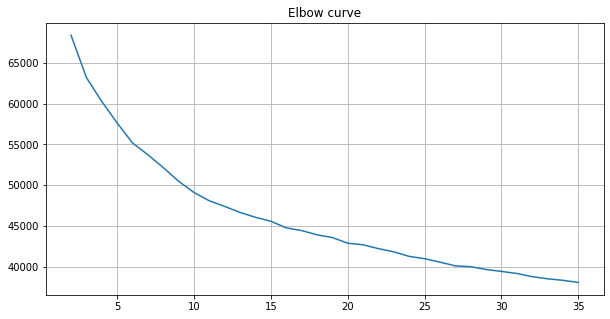

In [22]:
distorsions = []
for k in range(2, 36):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(anime_subset)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 36), distorsions)
plt.grid(True)
plt.title('Elbow curve')

### K-Means Results

Based on inertia, 10 clusters will best represent the anime titles and the cluster assignments will replace the genres

In [23]:
km_10 = KMeans(10)
g_clusters = km_10.fit(anime_subset)

In [24]:
anime_subset['cluster'] = g_clusters.labels_

In [25]:
anime_subset

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,Vampire,Yaoi,Yuri,Movie,ONA,OVA,Other,Special,TV,cluster
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,5
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,8
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,9
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,9


In [26]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(anime_subset[['cluster']])
cluster_10 = pd.DataFrame(enc.transform(anime_subset[['cluster']]), columns=['g_cluster_' + str(i) for i in range(1, 11)])

In [27]:
cluster_10 = cluster_10.astype('int')

In [28]:
# need the index (mal_id) from the genres dataframe
cluster_10.index = anime_subset.index

In [29]:
cluster_10

,g_cluster_1,g_cluster_2,g_cluster_3,g_cluster_4,g_cluster_5,g_cluster_6,g_cluster_7,g_cluster_8,g_cluster_9,g_cluster_10
mal_id,,,,,,,,,,
1,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,1,0,0,0,0
7,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
48481,0,0,0,0,0,0,0,0,1,0
48483,0,0,0,0,0,0,0,0,0,1
48488,0,0,0,0,0,0,0,0,0,1


## Replace the genres columns with clusters

Dimensionality was reduced from 74 to 39 columns

In [30]:
# drop the original genres columns
training_w_clusters = training.drop(columns=genres_list)
training_w_clusters = pd.merge(training_w_clusters, cluster_10, left_on='mal_id', right_index=True)
training_w_clusters.drop(columns=['mal_id'], inplace=True)

In [31]:
training_w_clusters.sort_values(['user_id']).set_index(['user_id', 'anime_id'])

user_rating  watching_status  watched_episodes  \
user_id anime_id                                                   
0       269                 9                3                64   
1       33486               8                2                25   
3       10379               8                2                13   
        9863                9                2                77   
        71                  7                2                24   
...                       ...              ...               ...   
353398  17247               8                3                 3   
        1571                7                2                25   
        36144               0                1                 0   
        32979               7                2                13   
353401  34662               0                6                 0   

                  aggregated_score  episodes  rating  ranked  popularity  \
user_id anime_id                                                           
0       269                   7.80     366.0       3   818.0          33   
1       33486                 8.33      25.0       3   203.0          13   
3       10379                 8.60      13.0       3    67.0         738   
        9863                  8.25      77.0       3   262.0         804   
        71                    7.65      24.0       5  1146.0         322   
...                            ...       ...     ...     ...         ...   
353398  17247                 7.15      12.0       4  3003.0         553   
        1571                  7.81      25.0       3   811.0         766   
        36144                 7.17      24.0       5  2907.0        2034   
        32979                 7.68      13.0       3  1084.0         949   
353401  34662                 7.16      25.0       5  2937.0         402   

                  members  score_10  ...  g_cluster_1  g_cluster_2  \
user_id anime_id                     ...                             
0       269       1286382  116063.0  ...            0            0   
1       33486     1611771  188165.0  ...            0            0   
3       10379      200904   23877.0  ...            0            0   
        9863       185346   11534.0  ...            1            0   
        71         411230   17675.0  ...            0            0   
...                   ...       ...  ...          ...          ...   
353398  17247      264089    7926.0  ...            0            0   
        1571       194354   11328.0  ...            1            0   
        36144       59132    1023.0  ...            0            0   
        32979      156048    5540.0  ...            0            0   
353401  34662      339526   12121.0  ...            0            0   

                  g_cluster_3  g_cluster_4  g_cluster_5  g_cluster_6  \
user_id anime_id                                                       
0       269                 0            0            0            1   
1       33486               0            0            0            1   
3       10379               0            0            0            1   
        9863                0            0            0            0   
        71                  0            0            0            1   
...                       ...          ...          ...          ...   
353398  17247               0            0            0            1   
        1571                0            0            0            0   
        36144               0            0            0            1   
        32979               0            0            0            1   
353401  34662               0            0            0            1   

                  g_cluster_7  g_cluster_8  g_cluster_9  g_cluster_10  
user_id anime_id                                                       
0       269                 0            0            0             0  
1       33486               0            0            0             0  
3       

In [32]:
# Do the same for anime_subset
anime_clusters = anime_subset.drop(columns=genres_list)
anime_clusters = pd.merge(anime_clusters, cluster_10, left_on='mal_id', right_index=True)

In [33]:
anime_clusters

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,g_cluster_1,g_cluster_2,g_cluster_3,g_cluster_4,g_cluster_5,g_cluster_6,g_cluster_7,g_cluster_8,g_cluster_9,g_cluster_10
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,0,0,0,0,0,1,0,0,0,0
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,0,0,0,0,0,1,0,0,0,0
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,0,0,0,0,0,1,0,0,0,0
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,0,0,0,0,0,1,0,0,0,0
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0,0,0,0,0,0,0,0,1,0
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,0,0,0,0,0,0,0,0,0,1
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0,0,0,0,0,0,0,0,0,1


# K Nearest Neighbors Model

Since we're using KNN in an unsupervised manner (no labels, no classifications) we will use NearestNeigbors vs KNeighborsClassifier

**Notes**
KNN will use the anime_subset with cluster assignments

In [34]:
knn = NearestNeighbors(metric="cosine")
knn.fit(anime_clusters)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

## Test Query

The test query will include itself as a recommendation, this will be excluded for final inferences

In [35]:
# Load the original anime table for title information from athena
anime = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'anime')).as_pandas()

### Query Title

In [36]:
anime[anime['mal_id'] == anime_clusters.iloc[1, :].name]

,mal_id,name,score,genres,english_name,japanese_name,type,episodes,aired,premiered,...,score_10,score_9,score_8,score_7,score_6,score_5,score_4,score_3,score_2,score_1
1117,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [37]:
distances, titles = knn.kneighbors(anime_clusters.iloc[1, :].values.reshape(1, -1), n_neighbors=10)

In [38]:
# Sort by distances, smallest to largest
distances

array([[0.        , 0.00019806, 0.00026596, 0.00031216, 0.00069917,
        0.00073396, 0.00076065, 0.00080426, 0.00085417, 0.00086291]])

In [39]:
# Recommendation rows ordered by distances
list(titles[0])

[1, 2215, 2813, 6893, 6229, 8139, 2373, 14023, 5897, 409]

In [40]:
# Convert rows to anime_ids
anime_clusters.iloc[list(titles[0]), :].index.tolist()

[5, 2418, 5205, 9260, 7472, 25537, 4282, 37055, 6675, 437]

### Recommended Titles based on Query

In [41]:
anime[anime['mal_id'].isin(anime_clusters.iloc[list(titles[0]), :].index.tolist())][['mal_id', 'name', 'genres']]

,mal_id,name,genres
1099,2418,Stranger: Mukou Hadan,"Action, Adventure, Historical, Samurai"
1117,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space"
1525,437,Perfect Blue,"Dementia, Drama, Horror, Psychological"
3578,4282,Kara no Kyoukai 5: Mujun Rasen,"Action, Mystery, Supernatural, Drama, Romance,..."
4018,5205,Kara no Kyoukai 7: Satsujin Kousatsu (Go),"Action, Mystery, Supernatural, Romance, Thriller"
5897,6675,Redline,"Action, Sci-Fi, Cars, Sports"
6229,7472,Gintama Movie 1: Shinyaku Benizakura-hen,"Action, Sci-Fi, Comedy, Historical, Parody, Sa..."
6893,9260,Kizumonogatari I: Tekketsu-hen,Vampire
8139,25537,Fate/stay night Movie: Heaven's Feel - I. Pres...,"Action, Fantasy, Magic, Supernatural"
14023,37055,Youjo Senki Movie,"Action, Military, Magic"


# Adding NLP Embeddings of Anime Synopsis Data using BERT

BERT model inferences are on the Team3_Modeling_BERT.ipynb notebook. See the note

In [42]:
# Pull Synopsis from Athena
synopsis = cursor.execute('SELECT * FROM %s.%s' % (dbname, 'synopsis')).as_pandas()
# Semantics is downloaded from S3
embeddings = pd.read_csv('Data/semantics.csv')

In [43]:
embeddings = pd.concat([synopsis[['mal_id']], embeddings], axis=1)
embeddings.set_index(['mal_id'], inplace=True)

In [44]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
mal_id,,,,,,,,,,,,,,,,,,,,,
1,-0.338000,0.280912,0.316794,-0.081068,0.229358,-0.153148,-0.447823,0.525362,0.265396,-0.106113,...,-0.887086,0.158227,-0.095016,0.038595,0.107712,-0.243573,-0.090685,-0.082259,0.366798,-0.188894
5,-0.025266,-0.049519,0.394098,-0.144688,0.058020,-0.056215,-0.152939,0.453019,0.189982,0.088776,...,-0.925842,-0.115866,-0.085770,-0.468572,-0.072172,0.015078,-0.120486,0.005637,0.211060,-0.038622
6,-0.050121,0.361339,0.314151,0.030035,-0.018952,-0.169436,0.143299,0.653574,0.067216,0.066807,...,-0.699382,0.128695,0.588282,-0.257558,0.276342,0.132950,-0.047471,-0.000429,0.647236,-0.094455
7,-0.277991,-0.150378,0.051548,-0.052691,0.007375,-0.371882,0.255686,-0.042258,0.262719,0.135156,...,-0.490768,-0.326309,0.118539,-0.256842,-0.066406,-0.026164,-0.191518,-0.156832,0.019953,0.001370
8,-0.460624,-0.038628,0.111783,-0.103765,-0.212746,0.000713,0.400580,0.219770,0.255605,-0.086178,...,-0.709232,-0.420919,0.098211,-0.308744,-0.238373,0.105808,-0.230327,0.046714,0.237139,-0.073872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,-0.224903,-0.046536,0.105933,0.138320,0.308536,-0.486385,-0.147109,0.669781,-0.125035,-0.394241,...,0.076944,0.367996,-0.870528,-0.305757,0.010205,0.025413,-0.210676,-0.458167,0.639832,0.115506
48483,-0.334284,0.088137,-0.028772,-0.419087,0.146186,0.032084,0.498137,0.263859,0.312464,-0.129219,...,-0.257484,-0.269723,0.116594,-0.221381,-0.304173,-0.068555,0.008158,0.153852,0.174848,0.095812
48488,-0.818853,-0.930333,-0.327279,-0.424246,-0.954531,-0.041453,0.148937,-0.311416,0.090937,0.274851,...,0.414920,-1.015739,-0.041265,-0.171408,-0.161529,-0.068896,0.426150,-0.309882,-0.275953,0.215306


In [45]:
# join embeddings on anime_clusters dataframe
anime_embeddings = pd.merge(anime_clusters, embeddings, left_index=True, right_index=True, how='left')

In [46]:
anime_embeddings

,score,episodes,rating,ranked,popularity,members,score_10,score_9,score_8,score_7,...,758,759,760,761,762,763,764,765,766,767
mal_id,,,,,,,,,,,,,,,,,,,,,
1,3.044157e+00,0.008181,0.8,0.001774,0.002220,0.483466,0.320601,0.340261,0.286693,0.205156,...,-0.887086,0.158227,-0.095016,0.038595,0.107712,-0.243573,-0.090685,-0.082259,0.366798,-0.188894
5,2.521152e+00,0.000000,0.8,0.010076,0.029490,0.105479,0.042028,0.091919,0.107826,0.074490,...,-0.925842,-0.115866,-0.085770,-0.468572,-0.072172,0.015078,-0.120486,0.005637,0.211060,-0.038622
6,2.319997e+00,0.008181,0.4,0.016857,0.011443,0.215834,0.070268,0.141336,0.187625,0.162703,...,-0.699382,0.128695,0.588282,-0.257558,0.276342,0.132950,-0.047471,-0.000429,0.647236,-0.094455
7,1.019190e+00,0.008181,0.4,0.157224,0.083518,0.036563,0.003051,0.008977,0.022058,0.038237,...,-0.490768,-0.326309,0.118539,-0.256842,-0.066406,-0.026164,-0.191518,-0.156832,0.019953,0.001370
8,6.302889e-01,0.016688,0.2,0.235108,0.248733,0.005106,0.000435,0.000986,0.002703,0.005635,...,-0.709232,-0.420919,0.098211,-0.308744,-0.238373,0.105808,-0.230327,0.046714,0.237139,-0.073872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,7.146486e-15,0.000327,1.0,0.500380,0.746712,0.000136,0.000053,0.000131,0.000198,0.000000,...,0.076944,0.367996,-0.870528,-0.305757,0.010205,0.025413,-0.210676,-0.458167,0.639832,0.115506
48483,7.146486e-15,0.000327,1.0,0.500380,0.999829,0.002707,0.000053,0.000131,0.000198,0.000458,...,-0.257484,-0.269723,0.116594,-0.221381,-0.304173,-0.068555,0.008158,0.153852,0.174848,0.095812
48488,7.146486e-15,0.000327,0.8,0.500380,0.999601,0.004367,0.000000,0.000131,0.000198,0.000458,...,0.414920,-1.015739,-0.041265,-0.171408,-0.161529,-0.068896,0.426150,-0.309882,-0.275953,0.215306


In [47]:
# For titles with no synopsis fill 0
anime_embeddings = anime_embeddings.fillna(0)

# KNN Recommendations using NLP Embeddings

In [48]:
knn_e = NearestNeighbors(metric="cosine")
knn_e.fit(anime_embeddings)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

### Test Query

In [49]:
anime[anime['mal_id'] == anime_embeddings.iloc[1, :].name]

,mal_id,name,score,genres,english_name,japanese_name,type,episodes,aired,premiered,...,score_10,score_9,score_8,score_7,score_6,score_5,score_4,score_3,score_2,score_1
1117,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0


In [50]:
distances, titles = knn_e.kneighbors(anime_embeddings.iloc[1, :].values.reshape(1, -1), n_neighbors=10)

In [51]:
distances

array([[0.        , 0.07331998, 0.07454903, 0.07488714, 0.07849818,
        0.07853637, 0.07978431, 0.08434003, 0.08455094, 0.0848173 ]])

In [52]:
list(titles[0])

[1, 1234, 439, 711, 10967, 6436, 376, 12714, 3584, 2297]

In [53]:
# Convert rows to anime_ids
anime_embeddings.iloc[list(titles[0]), :].index.tolist()

[5, 1365, 468, 781, 31490, 8100, 400, 34944, 2593, 4106]

### Recommendations using KNN + NLP Embeddings

In [54]:
pd.merge(anime_embeddings.iloc[list(titles[0]), [1]], anime, left_index=True, right_on='mal_id')[['mal_id', 'name', 'genres', 'rating']]

,mal_id,name,genres,rating
1117,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space",R - 17+ (violence & profanity)
118,1365,Detective Conan Movie 06: The Phantom of Baker...,"Adventure, Mystery, Police, Shounen",PG-13 - Teens 13 or older
1555,468,Innocence,"Military, Sci-Fi, Police, Psychological, Mecha",R - 17+ (violence & profanity)
1827,781,Detective Conan Movie 03: The Last Wizard of t...,"Adventure, Mystery, Comedy, Police, Shounen",PG-13 - Teens 13 or older
10967,31490,One Piece Film: Gold,"Action, Adventure, Comedy, Drama, Fantasy, Sho...",PG-13 - Teens 13 or older
6436,8100,Mardock Scramble: The First Compression,"Action, Sci-Fi, Psychological",R+ - Mild Nudity
1492,400,Seihou Bukyou Outlaw Star,"Action, Sci-Fi, Adventure, Space, Comedy",R+ - Mild Nudity
12714,34944,Bungou Stray Dogs: Dead Apple,"Action, Comedy, Mystery, Super Power, Supernat...",R - 17+ (violence & profanity)
2379,2593,Kara no Kyoukai 1: Fukan Fuukei,"Action, Mystery, Supernatural, Thriller",R - 17+ (violence & profanity)
3502,4106,Trigun: Badlands Rumble,"Action, Adventure, Comedy, Drama, Sci-Fi, Shounen",PG-13 - Teens 13 or older


# Recommender Systems

There will be 3 for evaluation:

 1. A Naive System that generates recommendations by uniformly random selection of titles
 2. Simpler Recommendation System using only feature set and clustering
 3. A comprehensive Recommendation system that includes feature set, clustering and Synopsis Embeddings using BERT


### Naive Recommender

This is a baseline system that is unskilled and generates k uniformly random recommendations from the anime titles

In [57]:
# This version is the naive recommender
def naive_recommendations(user_id, k=10):
    """
    user_id: The user_id in the anime_list table
    k: The top k recommendations

    Returns: Dataframe of top k titles
    """

    # Filter by user_id and remove titles from anime_embeddings if title watching status is 1 or 2
    user = training_w_clusters[training_w_clusters['user_id'] == user_id].sort_values(['user_rating'], ascending=False)
    # list of already watched titles
    already_watched = user[user['watching_status'].isin([1, 2])]['anime_id'].values.tolist()
    
    # Filtered anime table 
    anime_filtered = anime[~anime['mal_id'].isin(already_watched)]
    
    return anime_filtered.sample(k, replace=False, random_state=42)[['mal_id', 'name', 
                                                                     'score', 'genres', 'rating']].reset_index(drop=True)

In [58]:
# Test using user_id = 353398
naive_recommendations(353398, 10)

,mal_id,name,score,genres,rating
0,41220,Huo Feng Liao Yuan,Unknown,"Action, Adventure, Historical, Martial Arts",Unknown
1,40594,Tatoeba Last Dungeon Mae no Mura no Shounen ga...,6.75,"Adventure, Fantasy",Unknown
2,34659,Otokonoko ♂ Delivery,5.86,"Hentai, Yaoi",Rx - Hentai
3,10755,Lupin tai Holmes,6.08,Mystery,Unknown
4,41212,Niplheim no Karyuudo,5.29,Hentai,Rx - Hentai
5,2030,El Cazador de la Bruja,7.24,"Adventure, Drama, Mystery",PG-13 - Teens 13 or older
6,28201,Yeonghongibyeong Lazenca,Unknown,"Action, Adventure, Mecha, Sci-Fi",Unknown
7,2972,Kindan no Mokushiroku: Crystal Triangle,4.62,"Adventure, Military, Demons, Mystery",PG-13 - Teens 13 or older
8,36548,Kokkoku,7.04,"Psychological, Supernatural, Drama, Mystery, S...",R - 17+ (violence & profanity)
9,8039,Oppai no Ouja 48,7.01,Hentai,Rx - Hentai


### Recommender using clustering only

In [59]:
# This version is the simple recommender system without BERT embeddings
def simple_recommendations(user_id, k=10):
    """
    user_id: The user_id in the anime_list table
    k: The top k recommendations

    Returns: Dataframe of top k titles
    """

    # Filter by user_id and remove titles from anime_embeddings if title watching status is 1 or 2
    user = training_w_clusters[training_w_clusters['user_id'] == user_id].sort_values(['user_rating'], ascending=False)
    # anime_id of highest rated
    highest_rated = user['anime_id'].values.tolist()[0]
    # list of already watched titles
    already_watched = user[user['watching_status'].isin([1, 2])]['anime_id'].values.tolist()
    
    # Filtered anime table 
    anime_filtered = anime_clusters[~anime_clusters.index.isin(already_watched)]
    # Query point
    query = anime_clusters[anime_clusters.index == highest_rated]
    
    # KNN model on filtered anime table
    knn = NearestNeighbors(metric="cosine")
    knn.fit(anime_filtered)
    
    distances, titles = knn.kneighbors(query.values.reshape(1, -1), n_neighbors=k)
    row_list = list(titles[0])
    # Convert row list to anime ids
    anime_ids = anime_filtered.iloc[row_list, :].index.tolist()
    
    return pd.merge(anime_filtered.iloc[row_list, [1]], anime, left_index=True, right_on='mal_id')[['mal_id', 'name', 
                                                                                                    'score', 'genres', 'rating']].reset_index(drop=True)

In [60]:
# Test using user_id = 353398
simple_recommendations(353398, 10)

,mal_id,name,score,genres,rating
0,17247,Machine-Doll wa Kizutsukanai,7.15,"Action, Ecchi, Fantasy, School",R+ - Mild Nudity
1,6747,Dance in the Vampire Bund,7.06,"Action, Supernatural, Vampire",R+ - Mild Nudity
2,14829,Fate/kaleid liner Prisma☆Illya,7.11,"Action, Comedy, Magic, Fantasy",PG-13 - Teens 13 or older
3,34662,Fate/Apocrypha,7.16,"Action, Supernatural, Drama, Magic, Fantasy",R - 17+ (violence & profanity)
4,34104,Knight's & Magic,7.13,"Action, Fantasy, Mecha, School",PG-13 - Teens 13 or older
5,34176,Zero kara Hajimeru Mahou no Sho,7.1,"Action, Adventure, Magic, Fantasy",PG-13 - Teens 13 or older
6,16035,Karneval (TV),7.14,"Action, Fantasy, Josei, Mystery, Sci-Fi",PG-13 - Teens 13 or older
7,18277,Strike the Blood,7.14,"Action, Harem, Supernatural, Ecchi, Vampire, F...",R+ - Mild Nudity
8,21085,Witch Craft Works,7.07,"Action, Fantasy, Magic, Seinen, Supernatural",PG-13 - Teens 13 or older
9,4896,Umineko no Naku Koro ni,7.13,"Mystery, Horror, Psychological, Supernatural",R - 17+ (violence & profanity)


### Recommender with clustering and BERT embeddings

 * Takes in a user_id from the animelist table.
 * Get the user's highest rated title. Filter out anime_embeddings table by already watched titles (watching_status 1 or 2) Don't want to recommend already watched titles
 * KNN will use the filtered anime_embeddings table
 * The query data point will be the user's highest rated title.
 * The k nearest neighbors to the query point will be the 10 top recommended titles.

In [61]:
def recommendations(user_id, k=10):
    """
    user_id: The user_id in the anime_list table
    k: The top k recommendations

    Returns: Dataframe of top k titles
    """

    # Filter by user_id and remove titles from anime_embeddings if title watching status is 1 or 2
    user = training_w_clusters[training_w_clusters['user_id'] == user_id].sort_values(['user_rating'], ascending=False)
    # anime_id of highest rated
    highest_rated = user['anime_id'].values.tolist()[0]
    # list of already watched titles
    already_watched = user[user['watching_status'].isin([1, 2])]['anime_id'].values.tolist()
    
    # Filtered anime table 
    anime_filtered = anime_embeddings[~anime_embeddings.index.isin(already_watched)]
    # Query point
    query = anime_embeddings[anime_embeddings.index == highest_rated]
    
    # KNN model on filtered anime table
    knn = NearestNeighbors(metric="cosine")
    knn.fit(anime_filtered)
    
    distances, titles = knn.kneighbors(query.values.reshape(1, -1), n_neighbors=k)
    row_list = list(titles[0])
    # Convert row list to anime ids
    anime_ids = anime_filtered.iloc[row_list, :].index.tolist()
    
    return pd.merge(anime_filtered.iloc[row_list, [1]], anime, left_index=True, right_on='mal_id')[['mal_id', 'name', 'score', 
                                                                                                    'genres', 'rating']].reset_index(drop=True)
    

In [62]:
# Test using user_id = 353398
recommendations(353398, 10)

,mal_id,name,score,genres,rating
0,17247,Machine-Doll wa Kizutsukanai,7.15,"Action, Ecchi, Fantasy, School",R+ - Mild Nudity
1,238,Rekka no Honoo,7.36,"Action, Adventure, Martial Arts, Shounen, Supe...",PG-13 - Teens 13 or older
2,9065,Hakuouki Hekketsuroku,7.62,"Action, Drama, Historical, Josei, Samurai, Sup...",R - 17+ (violence & profanity)
3,14075,Zetsuen no Tempest,7.99,"Action, Mystery, Psychological, Drama, Magic, ...",PG-13 - Teens 13 or older
4,34561,Re:Creators,7.57,"Action, Sci-Fi, Fantasy, Mecha",R - 17+ (violence & profanity)
5,3375,Kirepapa.,6.7,"Comedy, Drama, Romance, Yaoi",R+ - Mild Nudity
6,2116,Captain Tsubasa,7.3,"Action, Shounen, Sports",G - All Ages
7,9465,Break Blade 4: Sanka no Chi,7.87,"Action, Fantasy, Mecha, Military, Shounen",R - 17+ (violence & profanity)
8,36934,Captain Tsubasa (2018),7.42,"Action, Sports, Shounen",G - All Ages
9,26159,Shinken Seminar Koukou Kouza,Unknown,"School, Shounen",PG-13 - Teens 13 or older


# Model Evaluation

Since there are over 240,000 users to create recommendations for, we will use a random sample of 100 users to generate recommendations for. There are 3 models to be evaluated. First a naive model that generates 10 recommendations (uniformly sampled from the 17,562 anime titles) for each of the 100 sampled users. Second is a simple version of the recommender system that does not use the synopsis embeddings from BERT. Third a more comprehensive model that uses the synopsis embeddings from BERT.

The models will evaluated using Personalization (cosine similarity) to measure recommendation similarity or dissimilarity between users and Intra-list similarity which evaluates how similar recommendations are for each user.

Ideally you would want a higher average personalization score which demonstrates more personalized experience for each user. The intra-list similarity for each user measures how similar each recommended title is a higher intra-list similarity measure means that the system is providing relevant or closely related recommendations (i.e not random).

### Create Batch recommendations from each recommender system for evaluation

Will randomly select 100 user create recommendations from each system and store in s3 for evaluation

In [63]:
# 100 random sample of users
eval_users = pd.Series(training_w_clusters['user_id'].unique()).sample(100, replace=False, random_state=42).values.tolist()

In [64]:
from IPython.display import clear_output

naive = []
simple = []
comprehensive = []
# Ten recommendations for each user
k=10

for i, user_id in enumerate(eval_users):
    clear_output(wait=True)
    
    n_rec = naive_recommendations(user_id, k)
    n_rec['user_id'] = user_id
    naive.append(n_rec)
    
    s_rec = simple_recommendations(user_id, k)
    s_rec['user_id'] = user_id
    simple.append(s_rec)
    
    c_rec = recommendations(user_id, k)
    c_rec['user_id'] = user_id
    comprehensive.append(c_rec)
    
    print('%d of %d users' % (i, len(eval_users)))

99 of 100 users


In [65]:
naive_recs = pd.concat(naive, axis=0)
naive_recs.set_index(['user_id']).to_csv('Data/naive_recommendations.csv', index=True)

simple_recs = pd.concat(simple, axis=0)
simple_recs.set_index(['user_id']).to_csv('Data/simple_recommendations.csv', index=True)

comp_recs = pd.concat(comprehensive, axis=0)
comp_recs.set_index(['user_id']).to_csv('Data/comprehensive_recommendations.csv', index=True)

In [66]:
def upload_file(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = os.path.basename(file_name)

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True

In [67]:
upload_file('Data/naive_recommendations.csv', 'ads508team3', 'modeling/naive_recommendations.csv')
upload_file('Data/simple_recommendations.csv', 'ads508team3', 'modeling/simple_recommendations.csv')
upload_file('Data/comprehensive_recommendations.csv', 'ads508team3', 'modeling/comprehensive_recommendations.csv')

True

## Metrics and Evaluation